digital option
Variance of phi: 1.373632312684503e-05
Variance of MC: 2.4939019190373113e-05
Price of regression: 0.5609448159432409 Price of MC: 0.5598259000000001
Mean of xi (MC): 0.02 Mean of xi (phi): 0.019881642788173823
Variance of xi (MC): 0.09960000000000001 Variance of xi (phi): 5.311718979506588e-05


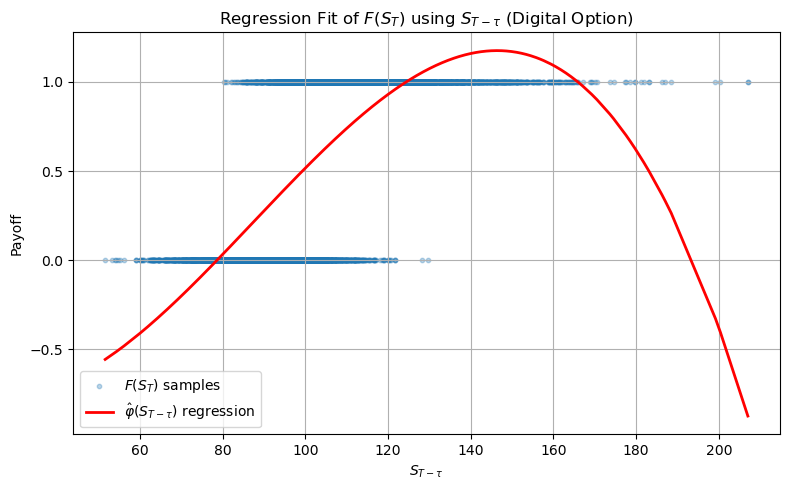

In [ ]:
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

class RNG:
    def __init__(self, seed=None):
        self.rng = np.random.default_rng()

    def normal(self, size, seed = 1):
        rng = np.random.default_rng(seed)
        return rng.standard_normal(size)
    

class Payoff:
    def __init__(self, strike, option_type='call', barrier=None, upper_strike=None, times=None, delta=None, trigger_strike = None):
        self.strike = strike
        self.option_type = option_type
        self.barrier = barrier
        self.upper_strike = upper_strike  # for double digital
        self.times = times                # for discretely monitored barrier
        self.delta = delta                # for rounded payoff
        self.trigger_strike = trigger_strike  # for gap option

    def __call__(self, prices):
        if self.option_type == 'digital':
            return (prices > self.strike).astype(float)

        elif self.option_type == 'double_digital':
            if self.upper_strike is None:
                raise ValueError("upper_strike is required for double digital payoff")
            return ((prices > self.strike) & (prices < self.upper_strike)).astype(float)

        elif self.option_type == 'one_touch_up':
            # prices: shape (N, M), assume barrier is monitored over time
            if self.barrier is None:
                raise ValueError("barrier is required for one-touch payoff")
            return (np.max(prices, axis=1) > self.barrier).astype(float)

        elif self.option_type == 'digital_lookback':
            # digital lookback: 1 if min(S_t) > K
            return (np.min(prices, axis=1) > self.strike).astype(float)

        elif self.option_type == 'discrete_barrier':
            if self.barrier is None or self.times is None:
                raise ValueError("barrier and times required for discrete barrier payoff")
            monitored_prices = prices[:, self.times]  # assume prices shape (N, M), times is list of indices
            return (np.max(monitored_prices, axis=1) > self.barrier).astype(float)

        elif self.option_type == 'rounded':
            if self.delta is None:
                raise ValueError("delta is required for rounded payoff")
            return np.floor(prices / self.delta) * self.delta
        elif self.option_type == 'gap':
            if self.trigger_strike is None:
                raise ValueError("trigger_strike is required for gap option")
            if np.ndim(prices) == 2:
                prices = prices[:, -1]  # assume final time step
            return ((prices > self.trigger_strike) * (prices - self.strike)).astype(float)

        else:
            raise Exception(f"Unsupported option_type: {self.option_type}")



class Market:
    def __init__(self, spot, r_t, sigma_t, times):
        self.spot = spot
        self.r_t = r_t
        self.sigma_t = sigma_t
        self.times = times

class PathGenerator:
    def __init__(self, market):
        self.spot = market.spot
        self.r_t = market.r_t
        self.sigma_t = market.sigma_t
        self.times = np.array(market.times)


# Monte carlo simulation of a path
    def generate_paths(self, N, random_matrix):
        M = len(self.times)
        paths = np.zeros((N, M))
        paths[:, 0] = self.spot
        for i in range(1, M):
            dt = self.times[i] - self.times[i - 1]
            r = self.r_t(self.times[i - 1])
            sigma = self.sigma_t(self.times[i - 1])
            paths[:, i] = paths[:, i - 1] * np.exp((r - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * random_matrix[:, i - 1])
        return paths
    

def second_basis_function(x):
    return np.column_stack([np.ones_like(x), x, x**2, x**3])

def longstaff_regression(X, Y):
    Phi_x = second_basis_function(X)
    model = LinearRegression(fit_intercept = False)
    model.fit(Phi_x, Y)
    beta = model.coef_

    def phi(x_new):
        x_new = np.atleast_1d(x_new)
        return second_basis_function(x_new) @ beta
    
    return phi, beta






N = 10000
times = [0.0, 0.8, 1.0]
strike = 100

delta = 1e-3
spot = 100
market = Market(spot, lambda t: 0.05, lambda t: 0.2, times)
market_u = Market(spot * (1 + delta), lambda t: 0.05, lambda t: 0.2, times)
market_l = Market(spot * (1 - delta), lambda t: 0.05, lambda t: 0.2, times)

seed_first = 1
# Generate Phi using first seed
## Setup
rng = RNG()
random_matrix = rng.normal(size=(N, len(times) - 1), seed = seed_first)
payoff = Payoff(strike, option_type='digital')
generator = PathGenerator(market)

## Simulate
paths = generator.generate_paths(N, random_matrix)
S_T_tau = paths[:, 1]  
# S_{T - τ}

F_S_T = payoff(paths[:, 2])  
F_S_T_2 = payoff(paths[:, 2])**2
# F(S_T)

phi, beta = longstaff_regression(S_T_tau, F_S_T)

# Generate a list of Y_pred using rest seed
Y_pred_list = []
Y_pred_list_2 = []
MC_price = []
MC_price_2 = []
seed_list = np.random.default_rng(seed=33).choice(np.arange(100, 10**9), size=1000, replace=False)


for i in range(0, len(seed_list)):
    seed_forloop = seed_list[i]
    random_matrix_forloop = rng.normal(size = (N, len(times) - 1), seed = seed_forloop)
    payoff = Payoff(strike, option_type='digital')
    generator = PathGenerator(market)
    #Simulate
    paths_forloop = generator.generate_paths(N, random_matrix_forloop)
    # S_(T - τ)
    S_T_tau_forloop = paths_forloop[:, 1]

    Phi_S_T_tau_forloop = phi(S_T_tau_forloop)
    #E(X^2) term
    Y_pred_list_2.append((np.mean(phi(S_T_tau_forloop)))**2)

    Y_pred_list.append(np.mean(Phi_S_T_tau_forloop))
    # F(S_T)  
    F_S_T_forloop = payoff(paths_forloop[:, 2])
    MC_price_2.append(np.mean(F_S_T_forloop)**2)
    MC_price.append(np.mean(F_S_T_forloop))

print("digital option")
# Calculate variance of phi
var_phi = 1/len(seed_list) * sum(Y_pred_list_2) - (1/len(seed_list) * sum(Y_pred_list))**2
print('Variance of phi:', var_phi)
# Calculate the variance of MC
var_MC = 1/len(seed_list) * sum(MC_price_2) - (1/len(seed_list) * sum(MC_price))**2
print('Variance of MC:', var_MC)

# Calculate the mean of Y_pred_list and MC_price
print("Price of regression:", np.mean(Y_pred_list), "Price of MC:", np.mean(MC_price))




## Compute \xi 
xi_mc = []
xi_phi = []

random_matrix_forloop = rng.normal(size = (N, len(times) - 1), seed = seed_list[0])
payoff = Payoff(strike, option_type='digital')
generator_u = PathGenerator(market_u)
#Simulate
paths_forloop_u = generator_u.generate_paths(N, random_matrix_forloop)

generator_l = PathGenerator(market_l)
paths_forloop_l = generator_l.generate_paths(N, random_matrix_forloop)
# store xi (mc)
xi_mc.extend(((payoff(paths_forloop_u[:, 2]) - payoff(paths_forloop_l[:, 2])) / (2 * delta * spot)).tolist())
xi_mc_squared = list(map(lambda x: x**2, xi_mc))

# store xi (phi)
xi_phi.extend(((phi(paths_forloop_u[:, 1]) - phi(paths_forloop_l[:, 1])) / (2 * delta * spot)).tolist())
xi_phi_squared = list(map(lambda x: x**2, xi_phi))

# Calculate the mean
print("Mean of xi (MC):", np.mean(xi_mc), "Mean of xi (phi):", np.mean(xi_phi))
# Calculate the variance
print("Variance of xi (MC):", 1/N * sum(xi_mc_squared) - (1/N * sum(xi_mc))**2, "Variance of xi (phi):", 1/N * sum(xi_phi_squared) - (1/N * sum(xi_phi))**2)


sorted_indices = np.argsort(S_T_tau)
S_sorted = S_T_tau[sorted_indices]
F_sorted = F_S_T[sorted_indices]
phi_fit = phi(S_sorted)

# 画图
plt.figure(figsize=(8, 5))
plt.scatter(S_T_tau, F_S_T, s=10, alpha=0.3, label='$F(S_T)$ samples')
plt.plot(S_sorted, phi_fit, color='red', linewidth=2.0, label=r'$\hat{\varphi}(S_{T-\tau})$ regression')
plt.xlabel(r'$S_{T-\tau}$')
plt.ylabel(r'Payoff')
plt.title('Regression Fit of $F(S_T)$ using $S_{T-\\tau}$ (Digital Option)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()




In [17]:
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

print('if coefficient is not fixed')

class RNG:
    def __init__(self, seed=None):
        self.rng = np.random.default_rng()

    def normal(self, size, seed = 1):
        rng = np.random.default_rng(seed)
        return rng.standard_normal(size)
    

class Payoff:
    def __init__(self, strike, option_type='call', barrier=None, upper_strike=None, times=None, delta=None, trigger_strike = None):
        self.strike = strike
        self.option_type = option_type
        self.barrier = barrier
        self.upper_strike = upper_strike  # for double digital
        self.times = times                # for discretely monitored barrier
        self.delta = delta                # for rounded payoff
        self.trigger_strike = trigger_strike  # for gap option

    def __call__(self, prices):
        if self.option_type == 'digital':
            return (prices > self.strike).astype(float)

        elif self.option_type == 'double_digital':
            if self.upper_strike is None:
                raise ValueError("upper_strike is required for double digital payoff")
            return ((prices > self.strike) & (prices < self.upper_strike)).astype(float)

        elif self.option_type == 'one_touch_up':
            # prices: shape (N, M), assume barrier is monitored over time
            if self.barrier is None:
                raise ValueError("barrier is required for one-touch payoff")
            return (np.max(prices, axis=1) > self.barrier).astype(float)

        elif self.option_type == 'digital_lookback':
            # digital lookback: 1 if min(S_t) > K
            return (np.min(prices, axis=1) > self.strike).astype(float)

        elif self.option_type == 'discrete_barrier':
            if self.barrier is None or self.times is None:
                raise ValueError("barrier and times required for discrete barrier payoff")
            monitored_prices = prices[:, self.times]  # assume prices shape (N, M), times is list of indices
            return (np.max(monitored_prices, axis=1) > self.barrier).astype(float)

        elif self.option_type == 'rounded':
            if self.delta is None:
                raise ValueError("delta is required for rounded payoff")
            return np.floor(prices / self.delta) * self.delta
        elif self.option_type == 'gap':
            if self.trigger_strike is None:
                raise ValueError("trigger_strike is required for gap option")
            if np.ndim(prices) == 2:
                prices = prices[:, -1]  # assume final time step
            return ((prices > self.trigger_strike) * (prices - self.strike)).astype(float)

        else:
            raise Exception(f"Unsupported option_type: {self.option_type}")



class Market:
    def __init__(self, spot, r_t, sigma_t, times):
        self.spot = spot
        self.r_t = r_t
        self.sigma_t = sigma_t
        self.times = times

class PathGenerator:
    def __init__(self, market):
        self.spot = market.spot
        self.r_t = market.r_t
        self.sigma_t = market.sigma_t
        self.times = np.array(market.times)


# Monte carlo simulation of a path
    def generate_paths(self, N, random_matrix):
        M = len(self.times)
        paths = np.zeros((N, M))
        paths[:, 0] = self.spot
        for i in range(1, M):
            dt = self.times[i] - self.times[i - 1]
            r = self.r_t(self.times[i - 1])
            sigma = self.sigma_t(self.times[i - 1])
            paths[:, i] = paths[:, i - 1] * np.exp((r - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * random_matrix[:, i - 1])
        return paths
    

def second_basis_function(x):
    return np.column_stack([np.ones_like(x), x, x**2, x**3])

def longstaff_regression(X, Y):
    Phi_x = second_basis_function(X)
    model = LinearRegression(fit_intercept = False)
    model.fit(Phi_x, Y)
    beta = model.coef_

    def phi(x_new):
        x_new = np.atleast_1d(x_new)
        return second_basis_function(x_new) @ beta
    
    return phi, beta






N = 10000
times = [0.0, 0.8, 1.0]
K = 100

delta = 1e-3
spot = 100
market = Market(spot, lambda t: 0.05, lambda t: 0.2, times)
market_u = Market(spot * (1 + delta), lambda t: 0.05, lambda t: 0.2, times)
market_l = Market(spot * (1 - delta), lambda t: 0.05, lambda t: 0.2, times)

seed_first = 1
# Generate Phi using first seed
## Setup
rng = RNG()
random_matrix = rng.normal(size=(N, len(times) - 1), seed = seed_first)
payoff = Payoff(K, option_type='digital')
generator = PathGenerator(market)

## Simulate
paths = generator.generate_paths(N, random_matrix)
S_T_tau = paths[:, 1]  
# S_{T - τ}

F_S_T = payoff(paths[:, 2])  
F_S_T_2 = payoff(paths[:, 2])**2
# F(S_T)

phi, beta = longstaff_regression(S_T_tau, F_S_T)

# Generate a list of Y_pred using rest seed
Y_pred_list = []
Y_pred_list_2 = []
MC_price = []
MC_price_2 = []
seed_list = np.random.default_rng(seed=33).choice(np.arange(100, 10**9), size=1000, replace=False)



for i in range(0, len(seed_list)):
    seed_forloop = seed_list[i]
    random_matrix_forloop = rng.normal(size = (N, len(times) - 1), seed = seed_forloop)
    payoff = Payoff(K, option_type='digital')
    generator = PathGenerator(market)
    #Simulate
    paths_forloop = generator.generate_paths(N, random_matrix_forloop)
    # S_(T - τ)
    S_T_tau_forloop = paths_forloop[:, 1]
    F_S_T_forloop = payoff(paths_forloop[:, 2])
    phi, beta = longstaff_regression(S_T_tau_forloop, F_S_T_forloop)

    Phi_S_T_tau_forloop = phi(S_T_tau_forloop)
    #E(X^2) term
    Y_pred_list_2.append((np.mean(phi(S_T_tau_forloop)))**2)

    Y_pred_list.append(np.mean(Phi_S_T_tau_forloop))
    # F(S_T)  
    F_S_T_forloop = payoff(paths_forloop[:, 2])
    MC_price_2.append(np.mean(F_S_T_forloop)**2)
    MC_price.append(np.mean(F_S_T_forloop))

print("digital option")
# Calculate variance of phi
var_phi = 1/len(seed_list) * sum(Y_pred_list_2) - (1/len(seed_list) * sum(Y_pred_list))**2
print('Variance of phi:', var_phi)
# Calculate the variance of MC
var_MC = 1/len(seed_list) * sum(MC_price_2) - (1/len(seed_list) * sum(MC_price))**2
print('Variance of MC:', var_MC)

# Calculate the mean of Y_pred_list and MC_price
print("Price of regression:", np.mean(Y_pred_list), "Price of MC:", np.mean(MC_price))




## Compute \xi 
xi_mc = []
xi_phi = []

random_matrix_forloop = rng.normal(size = (N, len(times) - 1), seed = seed_list[0])
payoff = Payoff(K, option_type='digital')
generator_u = PathGenerator(market_u)
#Simulate
paths_forloop_u = generator_u.generate_paths(N, random_matrix_forloop)

generator_l = PathGenerator(market_l)
paths_forloop_l = generator_l.generate_paths(N, random_matrix_forloop)
# store xi (mc)
xi_mc.extend(((payoff(paths_forloop_u[:, 2]) - payoff(paths_forloop_l[:, 2])) / (2 * delta * spot)).tolist())
xi_mc_squared = list(map(lambda x: x**2, xi_mc))

# store xi (phi)
xi_phi.extend(((phi(paths_forloop_u[:, 1]) - phi(paths_forloop_l[:, 1])) / (2 * delta * spot)).tolist())
xi_phi_squared = list(map(lambda x: x**2, xi_phi))

# Calculate the mean
print("Mean of xi (MC):", np.mean(xi_mc), "Mean of xi (phi):", np.mean(xi_phi))
# Calculate the variance
print("Variance of xi (MC):", 1/N * sum(xi_mc_squared) - (1/N * sum(xi_mc))**2, "Variance of xi (phi):", 1/N * sum(xi_phi_squared) - (1/N * sum(xi_phi))**2)

    




if coefficient is not fixed
digital option
Variance of phi: 2.4939019196590362e-05
Variance of MC: 2.4939019190373113e-05
Price of regression: 0.5598258999924164 Price of MC: 0.5598259000000001
Mean of xi (MC): 0.02 Mean of xi (phi): 0.01972514465608935
Variance of xi (MC): 0.09960000000000001 Variance of xi (phi): 7.245804465267269e-05


<>:101: SyntaxWarning: invalid escape sequence '\ '
<>:101: SyntaxWarning: invalid escape sequence '\ '
/var/folders/xy/8pjc9t0921g400hwcbh21kxm0000gn/T/ipykernel_1160/3043324.py:101: SyntaxWarning: invalid escape sequence '\ '
  plt.title('Regression Fit of $F(S_T)$ using $S_{T-\\tau}\  (Double\ Digital\ Option)$')


double digital option
digital option
Variance of phi: 1.2739649251983232e-06
Variance of MC: 1.5347345589854233e-05
Price of regression: 0.18883906246324403 Price of MC: 0.1877771
Mean of xi (MC): 0.002 Mean of xi (phi): 0.0006187683375347896
Variance of xi (MC): 0.189996 Variance of xi (phi): 8.316737935800752e-05


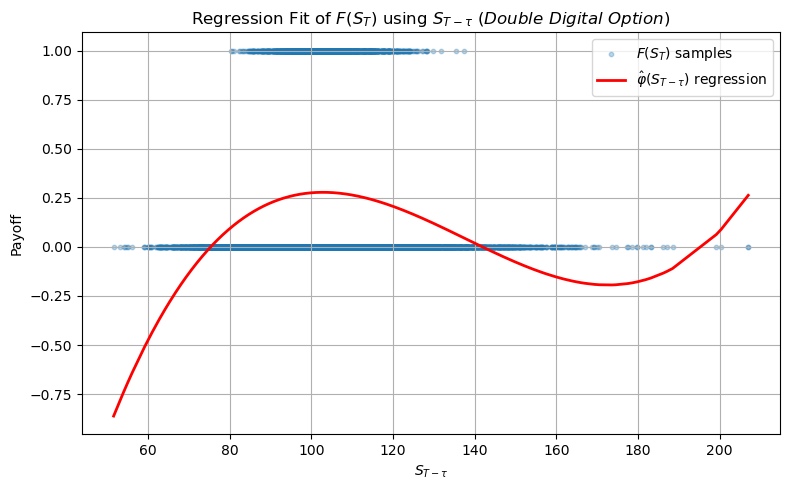

In [29]:
print("double digital option")
upper_strike = 110
seed_first = 1
# Generate Phi using first seed
## Setup
rng = RNG()
random_matrix = rng.normal(size=(N, len(times) - 1), seed = seed_first)
payoff = Payoff(K, option_type='double_digital', upper_strike=upper_strike)
generator = PathGenerator(market)

## Simulate
paths = generator.generate_paths(N, random_matrix)
S_T_tau = paths[:, 1]  
# S_{T - τ}

F_S_T = payoff(paths[:, 2])  
F_S_T_2 = payoff(paths[:, 2])**2
# F(S_T)

phi, beta = longstaff_regression(S_T_tau, F_S_T)

# Generate a list of Y_pred using rest seed
Y_pred_list = []
Y_pred_list_2 = []
MC_price = []
MC_price_2 = []
seed_list = np.random.default_rng(seed=33).choice(np.arange(100, 10**9), size=1000, replace=False)



for i in range(0, len(seed_list)):
    seed_forloop = seed_list[i]
    random_matrix_forloop = rng.normal(size = (N, len(times) - 1), seed = seed_forloop)
    payoff = Payoff(K, option_type='double_digital', upper_strike=upper_strike)
    generator = PathGenerator(market)
    #Simulate
    paths_forloop = generator.generate_paths(N, random_matrix_forloop)
    # S_(T - τ)
    S_T_tau_forloop = paths_forloop[:, 1]

    Phi_S_T_tau_forloop = phi(S_T_tau_forloop)
    #E(X^2) term
    Y_pred_list_2.append((np.mean(phi(S_T_tau_forloop)))**2)

    Y_pred_list.append(np.mean(Phi_S_T_tau_forloop))
    # F(S_T)  
    F_S_T_forloop = payoff(paths_forloop[:, 2])
    MC_price_2.append(np.mean(F_S_T_forloop)**2)
    MC_price.append(np.mean(F_S_T_forloop))

print("digital option")
# Calculate variance of phi
var_phi = 1/len(seed_list) * sum(Y_pred_list_2) - (1/len(seed_list) * sum(Y_pred_list))**2
print('Variance of phi:', var_phi)
# Calculate the variance of MC
var_MC = 1/len(seed_list) * sum(MC_price_2) - (1/len(seed_list) * sum(MC_price))**2
print('Variance of MC:', var_MC)

# Calculate the mean of Y_pred_list and MC_price
print("Price of regression:", np.mean(Y_pred_list), "Price of MC:", np.mean(MC_price))




## Compute \xi 
xi_mc = []
xi_phi = []

random_matrix_forloop = rng.normal(size = (N, len(times) - 1), seed = seed_list[0])
payoff = Payoff(K, option_type='double_digital', upper_strike=upper_strike)
generator_u = PathGenerator(market_u)
#Simulate
paths_forloop_u = generator_u.generate_paths(N, random_matrix_forloop)

generator_l = PathGenerator(market_l)
paths_forloop_l = generator_l.generate_paths(N, random_matrix_forloop)
# store xi (mc)
xi_mc.extend(((payoff(paths_forloop_u[:, 2]) - payoff(paths_forloop_l[:, 2])) / (2 * delta * spot)).tolist())
xi_mc_squared = list(map(lambda x: x**2, xi_mc))

# store xi (phi)
xi_phi.extend(((phi(paths_forloop_u[:, 1]) - phi(paths_forloop_l[:, 1])) / (2 * delta * spot)).tolist())
xi_phi_squared = list(map(lambda x: x**2, xi_phi))

# Calculate the mean
print("Mean of xi (MC):", np.mean(xi_mc), "Mean of xi (phi):", np.mean(xi_phi))
# Calculate the variance
print("Variance of xi (MC):", 1/N * sum(xi_mc_squared) - (1/N * sum(xi_mc))**2, "Variance of xi (phi):", 1/N * sum(xi_phi_squared) - (1/N * sum(xi_phi))**2)

sorted_indices = np.argsort(S_T_tau)
S_sorted = S_T_tau[sorted_indices]
F_sorted = F_S_T[sorted_indices]
phi_fit = phi(S_sorted)

# 画图
plt.figure(figsize=(8, 5))
plt.scatter(S_T_tau, F_S_T, s=10, alpha=0.3, label='$F(S_T)$ samples')
plt.plot(S_sorted, phi_fit, color='red', linewidth=2.0, label=r'$\hat{\varphi}(S_{T-\tau})$ regression')
plt.xlabel(r'$S_{T-\tau}$')
plt.ylabel(r'Payoff')
plt.title('Regression Fit of $F(S_T)$ using $S_{T-\\tau}\  (Double\ Digital\ Option)$')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

<>:102: SyntaxWarning: invalid escape sequence '\ '
<>:102: SyntaxWarning: invalid escape sequence '\ '
/var/folders/xy/8pjc9t0921g400hwcbh21kxm0000gn/T/ipykernel_1160/182742288.py:102: SyntaxWarning: invalid escape sequence '\ '
  plt.title('Regression Fit of $F(S_T)$ using $S_{T-\\tau} \ (Gap \ option)$')


Gap_option
Variance of phi: 0.022018079236488575
Variance of MC: 0.02857816064039298
Price of regression: 13.65683928440458 Price of MC: 13.791058149970738
Mean of xi (MC): 0.7670626522869567 Mean of xi (phi): 0.7563586992186327
Variance of xi (MC): 2.8086861924642754 Variance of xi (phi): 0.20087946661632894


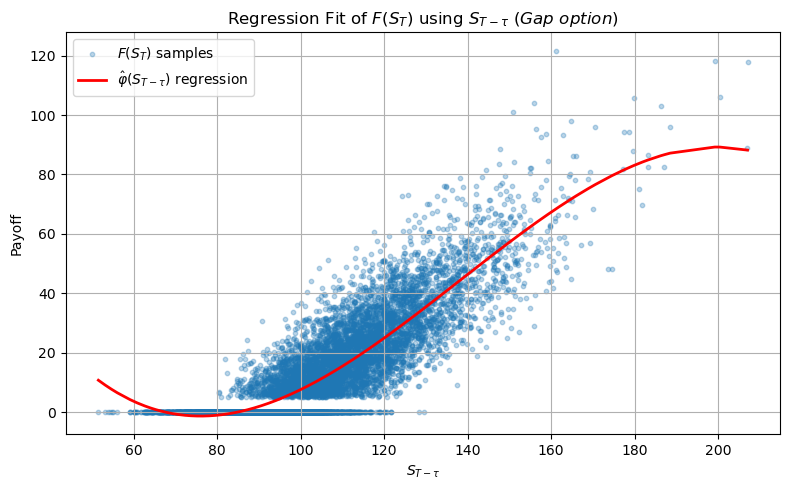

In [30]:
print('Gap_option')

trigger_strike = 100
strike = 95
seed_first = 1
# Generate Phi using first seed
## Setup
rng = RNG()
random_matrix = rng.normal(size=(N, len(times) - 1), seed = seed_first)
payoff = Payoff(strike, option_type='gap', trigger_strike = trigger_strike)
generator = PathGenerator(market)

## Simulate
paths = generator.generate_paths(N, random_matrix)
S_T_tau = paths[:, 1]  
# S_{T - τ}

F_S_T = payoff(paths)  
F_S_T_2 = payoff(paths)**2
# F(S_T)

phi, beta = longstaff_regression(S_T_tau, F_S_T)

# Generate a list of Y_pred using rest seed
Y_pred_list = []
Y_pred_list_2 = []
MC_price = []
MC_price_2 = []
seed_list = np.random.default_rng(seed=33).choice(np.arange(100, 10**9), size=1000, replace=False)



for i in range(0, len(seed_list)):
    seed_forloop = seed_list[i]
    random_matrix_forloop = rng.normal(size = (N, len(times) - 1), seed = seed_forloop)
    payoff = Payoff(strike, option_type='gap', trigger_strike = trigger_strike)
    generator = PathGenerator(market)
    #Simulate
    paths_forloop = generator.generate_paths(N, random_matrix_forloop)
    # S_(T - τ)
    S_T_tau_forloop = paths_forloop[:, 1]

    Phi_S_T_tau_forloop = phi(S_T_tau_forloop)
    #E(X^2) term
    Y_pred_list_2.append((np.mean(phi(S_T_tau_forloop)))**2)

    Y_pred_list.append(np.mean(Phi_S_T_tau_forloop))
    # F(S_T)  
    F_S_T_forloop = payoff(paths_forloop[:, 2])
    MC_price_2.append(np.mean(F_S_T_forloop)**2)
    MC_price.append(np.mean(F_S_T_forloop))

# Calculate variance of phi
var_phi = 1/len(seed_list) * sum(Y_pred_list_2) - (1/len(seed_list) * sum(Y_pred_list))**2
print('Variance of phi:', var_phi)
# Calculate the variance of MC
var_MC = 1/len(seed_list) * sum(MC_price_2) - (1/len(seed_list) * sum(MC_price))**2
print('Variance of MC:', var_MC)

# Calculate the mean of Y_pred_list and MC_price
print("Price of regression:", np.mean(Y_pred_list), "Price of MC:", np.mean(MC_price))




## Compute \xi 
xi_mc = []
xi_phi = []

random_matrix_forloop = rng.normal(size = (N, len(times) - 1), seed = seed_list[0])
payoff = Payoff(strike, option_type='gap', trigger_strike = trigger_strike)
generator_u = PathGenerator(market_u)
#Simulate
paths_forloop_u = generator_u.generate_paths(N, random_matrix_forloop)

generator_l = PathGenerator(market_l)
paths_forloop_l = generator_l.generate_paths(N, random_matrix_forloop)
# store xi (mc)
xi_mc.extend(((payoff(paths_forloop_u[:, 2]) - payoff(paths_forloop_l[:, 2])) / (2 * delta * spot)).tolist())
xi_mc_squared = list(map(lambda x: x**2, xi_mc))

# store xi (phi)
xi_phi.extend(((phi(paths_forloop_u[:, 1]) - phi(paths_forloop_l[:, 1])) / (2 * delta * spot)).tolist())
xi_phi_squared = list(map(lambda x: x**2, xi_phi))

# Calculate the mean
print("Mean of xi (MC):", np.mean(xi_mc), "Mean of xi (phi):", np.mean(xi_phi))
# Calculate the variance
print("Variance of xi (MC):", 1/N * sum(xi_mc_squared) - (1/N * sum(xi_mc))**2, "Variance of xi (phi):", 1/N * sum(xi_phi_squared) - (1/N * sum(xi_phi))**2)

sorted_indices = np.argsort(S_T_tau)
S_sorted = S_T_tau[sorted_indices]
F_sorted = F_S_T[sorted_indices]
phi_fit = phi(S_sorted)

# 画图
plt.figure(figsize=(8, 5))
plt.scatter(S_T_tau, F_S_T, s=10, alpha=0.3, label='$F(S_T)$ samples')
plt.plot(S_sorted, phi_fit, color='red', linewidth=2.0, label=r'$\hat{\varphi}(S_{T-\tau})$ regression')
plt.xlabel(r'$S_{T-\tau}$')
plt.ylabel(r'Payoff')
plt.title('Regression Fit of $F(S_T)$ using $S_{T-\\tau} \ (Gap \ option)$')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

compute var phi and var xi as tau changes
Mean of xi (MC): 0.539882403356608 Mean of xi (phi): 0.5527286131032864
Variance of xi (MC): 3.0211371464210037 Variance of xi (phi): 0.3060666949658541
Mean of xi (MC): 0.5173590338032035 Mean of xi (phi): 0.5597699309088899
Variance of xi (MC): 2.0886666205217286 Variance of xi (phi): 0.30606473070819884
Mean of xi (MC): 0.5645162332501293 Mean of xi (phi): 0.5598835656602406
Variance of xi (MC): 3.4787815225913548 Variance of xi (phi): 0.3015288764501106
Mean of xi (MC): 0.5434857560898361 Mean of xi (phi): 0.5622581981450817
Variance of xi (MC): 2.9465430822048226 Variance of xi (phi): 0.3065463059318349
Mean of xi (MC): 0.5481946575393718 Mean of xi (phi): 0.5559349987411327
Variance of xi (MC): 2.8689927555300767 Variance of xi (phi): 0.2899128032853161
Mean of xi (MC): 0.5304071137247464 Mean of xi (phi): 0.5569275115095845
Variance of xi (MC): 2.642238404758375 Variance of xi (phi): 0.2696057188320552
Mean of xi (MC): 0.5258176610157034

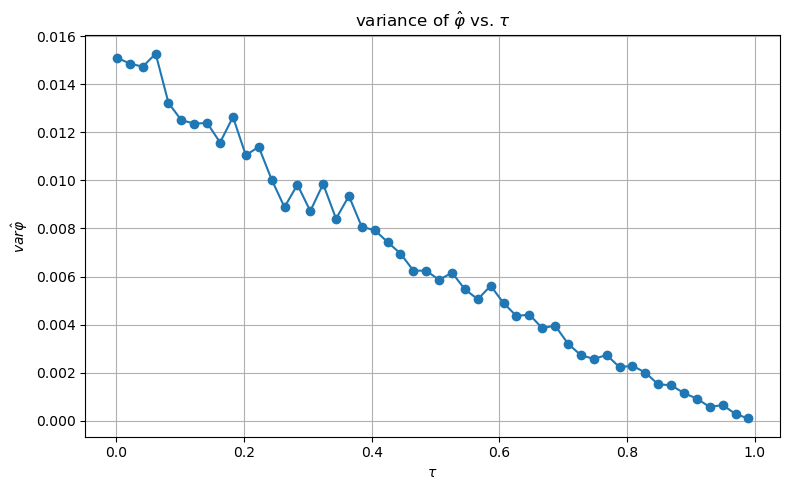

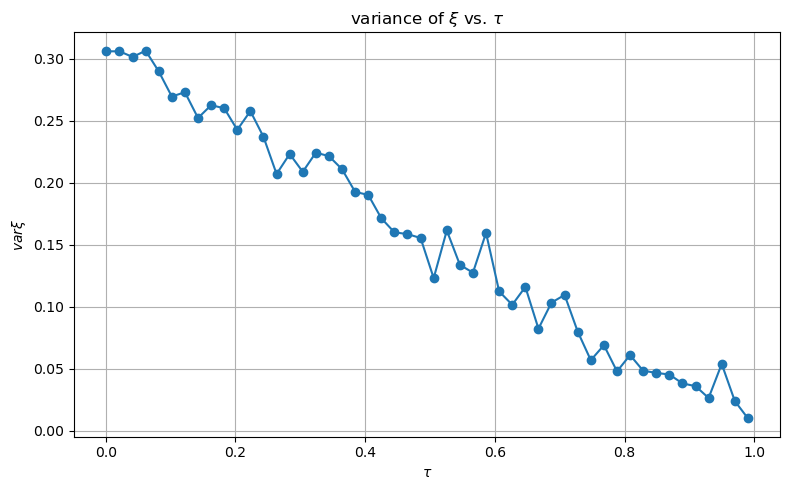

In [ ]:
print('compute var phi and var xi as tau changes (fixed coefficient)')
N = 10000
trigger_strike = 100
strike = 95
seed_first = 1
tau_values = np.round(np.linspace(0.001, 0.99, 50), 4)
varphi_list = []
varxi_list = []
i_seed = 0

for tau in tau_values:
    times = [0.0, 1.0 - tau, 1.0]


    market = Market(spot, lambda t: 0.05, lambda t: 0.2, times)
    market_u = Market(spot * (1 + delta), lambda t: 0.05, lambda t: 0.2, times)
    market_l = Market(spot * (1 - delta), lambda t: 0.05, lambda t: 0.2, times)

    # Generate Phi using first seed
    ## Setup
    rng = RNG()
    random_matrix = rng.normal(size=(N, len(times) - 1), seed = seed_first + i_seed)
    payoff = Payoff(strike, option_type='gap', trigger_strike = trigger_strike)
    generator = PathGenerator(market)

    ## Simulate
    paths = generator.generate_paths(N, random_matrix)
    S_T_tau = paths[:, 1]  
    # S_{T - τ}

    F_S_T = payoff(paths)  
    F_S_T_2 = payoff(paths)**2
    # F(S_T)

    phi, beta = longstaff_regression(S_T_tau, F_S_T)

    # Generate a list of Y_pred using rest seed
    Y_pred_list = []
    Y_pred_list_2 = []
    MC_price = []
    MC_price_2 = []
    seed_list = np.random.default_rng(seed=33+i_seed).choice(np.arange(100, 10**9), size=1000, replace=False)
    i_seed += 1


    for i in range(0, len(seed_list)):
        seed_forloop = seed_list[i]
        random_matrix_forloop = rng.normal(size = (N, len(times) - 1), seed = seed_forloop)
        payoff = Payoff(strike, option_type='gap', trigger_strike = trigger_strike)
        generator = PathGenerator(market)
        #Simulate
        paths_forloop = generator.generate_paths(N, random_matrix_forloop)
        # S_(T - τ)
        S_T_tau_forloop = paths_forloop[:, 1]

        Phi_S_T_tau_forloop = phi(S_T_tau_forloop)
        #E(X^2) term
        Y_pred_list_2.append((np.mean(phi(S_T_tau_forloop)))**2)

        Y_pred_list.append(np.mean(Phi_S_T_tau_forloop))
        # F(S_T)  
        F_S_T_forloop = payoff(paths_forloop[:, 2])
        MC_price_2.append(np.mean(F_S_T_forloop)**2)
        MC_price.append(np.mean(F_S_T_forloop))


    var_phi = 1/len(seed_list) * sum(Y_pred_list_2) - (1/len(seed_list) * sum(Y_pred_list))**2

    var_MC = 1/len(seed_list) * sum(MC_price_2) - (1/len(seed_list) * sum(MC_price))**2
    varphi_list.append(var_phi)
    ## Compute \xi 
    xi_mc = []
    xi_phi = []

    random_matrix_forloop = rng.normal(size = (N, len(times) - 1), seed = seed_list[0])
    payoff = Payoff(strike, option_type='gap', trigger_strike = trigger_strike)
    generator_u = PathGenerator(market_u)
    #Simulate
    paths_forloop_u = generator_u.generate_paths(N, random_matrix_forloop)

    generator_l = PathGenerator(market_l)
    paths_forloop_l = generator_l.generate_paths(N, random_matrix_forloop)
    # store xi (mc)
    xi_mc.extend(((payoff(paths_forloop_u[:, 2]) - payoff(paths_forloop_l[:, 2])) / (2 * delta * spot)).tolist())
    xi_mc_squared = list(map(lambda x: x**2, xi_mc))

    # store xi (phi)
    xi_phi.extend(((phi(paths_forloop_u[:, 1]) - phi(paths_forloop_l[:, 1])) / (2 * delta * spot)).tolist())
    xi_phi_squared = list(map(lambda x: x**2, xi_phi))

    # Calculate the mean
    print("Mean of xi (MC):", np.mean(xi_mc), "Mean of xi (phi):", np.mean(xi_phi))
    # Calculate the variance
    print("Variance of xi (MC):", 1/N * sum(xi_mc_squared) - (1/N * sum(xi_mc))**2, "Variance of xi (phi):", 1/N * sum(xi_phi_squared) - (1/N * sum(xi_phi))**2)
    varxi_list.append(1/N * sum(xi_phi_squared) - (1/N * sum(xi_phi))**2)

# Plotting varphi vs tau
plt.figure(figsize=(8, 5))
plt.plot(tau_values, varphi_list, marker='o')
plt.xlabel(r'$\tau$')
plt.ylabel(r'$var\hat\varphi$')
plt.title(r'variance of $\hat\varphi$ vs. $\tau$')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plotting varxi vs tau
plt.figure(figsize=(8, 5))
plt.plot(tau_values, varxi_list, marker='o')
plt.xlabel(r'$\tau$')
plt.ylabel(r'$var\xi$')
plt.title(r'variance of $\xi$ vs. $\tau$')
plt.grid(True)
plt.tight_layout()
plt.show()


/opt/anaconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:198: RuntimeWarni

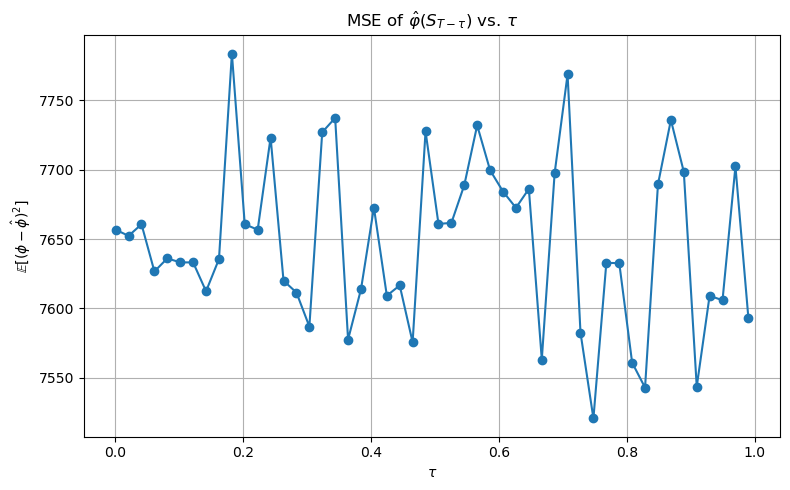

In [ ]:
print('compute bias^2 as tau changes')
trigger_strike = 100
strike = 95
N = 1000
N_true_phi = 10000
N_true = 50000
delta = 1e-3
spot = 90
tau_values = np.round(np.linspace(0.001, 0.99, 50), 4)
i_seed = 0
var_phi_list = []
var_mc_list = []
var_xi_mc_list = []
var_xi_phi_list = []
seed_list = np.random.default_rng(seed=33).choice(np.arange(1, 10**9), size=500000, replace=False)
mse_list = []



for tau in tau_values:
    times = [0.0, 1.0 - tau, 1.0]


    market = Market(spot, lambda t: 0.05, lambda t: 0.2, times)
    market_u = Market(spot * (1 + delta), lambda t: 0.05, lambda t: 0.2, times)
    market_l = Market(spot * (1 - delta), lambda t: 0.05, lambda t: 0.2, times)

    seed_first = 1 + i_seed
    # Generate 'true' Phi
    random_matrix_true = rng.normal((N, len(times) - 1), seed= seed_first + i_seed + 47)
    payoff_true = Payoff(strike, option_type='gap', trigger_strike = trigger_strike)
    paths_true = PathGenerator(market).generate_paths(N, random_matrix_true)
    S_T_tau_true = paths_true[:, 1]
    F_S_T_true = payoff_true(paths_true[:, 2])
    phi_hat, beta_true = longstaff_regression(S_T_tau_true, F_S_T_true)
    # Generate Phi using first seed
    ## Setup
    # rng = RNG()
    # random_matrix = rng.normal(size=(N, len(times) - 1), seed = seed_first + i_seed)
    # payoff = Payoff(strike, option_type='gap', trigger_strike = trigger_strike)
    # generator = PathGenerator(market)

    # ## Simulate
    # paths = generator.generate_paths(N, random_matrix)
    # S_T_tau = paths[:, 1]  
    # # S_{T - τ}

    # F_S_T = payoff(paths[:, 2])  
    # F_S_T_2 = payoff(paths[:, 2])**2
    # # F(S_T)

    # phi_hat, beta = longstaff_regression(S_T_tau, F_S_T)

    # Generate a list of Y_pred using rest seed
    Y_pred_list = []
    Y_pred_list_2 = []
    MC_price = []
    MC_price_2 = []
    


    mse_vals = []
    for i in range(0, 500):
        seed_forloop = seed_list[i + i_seed]
        random_matrix_forloop = rng.normal(size = (N_true, len(times) - 1), seed = seed_forloop)
        payoff = Payoff(strike, option_type='gap', trigger_strike = trigger_strike)
        generator = PathGenerator(market)
        #Simulate
        paths_forloop = generator.generate_paths(N_true, random_matrix_forloop)
        # S_(T - τ)
        S_T_tau_forloop = paths_forloop[:, 1]
        F_S_T_forloop = payoff(paths_forloop[:, 2])
        # using mc to find true phi()
        times_true_phi = [0.0, tau]
        market_true_phi = Market(np.mean(S_T_tau_forloop), lambda t: 0.05, lambda t: 0.2, times_true_phi)
        random_matrix_true_phi = rng.normal((N_true_phi, len(times_true_phi) - 1), seed= seed_first + i_seed + 66)
        paths_true_phi = PathGenerator(market_true_phi).generate_paths(N_true_phi, random_matrix_true_phi)
        true_phi = paths_true_phi[:, 1]




        # # Phi_S_T_tau_forloop = phi(S_T_tau_forloop)
        

        # #E(X^2) term
        # Y_pred_list_2.append((np.mean(phi(S_T_tau_forloop)))**2)

        # Y_pred_list.append(np.mean(Phi_S_T_tau_forloop))
        # # F(S_T)  
        # F_S_T_forloop = payoff(paths_forloop[:, 2])
        # MC_price_2.append(np.mean(F_S_T_forloop)**2)
        # MC_price.append(np.mean(F_S_T_forloop))
        # random_matrix_eval = rng.normal(size = (N, len(times) - 1), seed = seed_forloop + 500)
        # paths_eval = generator.generate_paths(N, random_matrix_eval)
        # S_T_tau_eval = paths_eval[:, 1]
        # F_S_T_eval = payoff(paths_eval[:, 2])
        mse = (np.mean(true_phi) - np.mean(phi_hat(S_T_tau_forloop)))**2
        mse_vals.append(mse)

    mse_list.append(np.mean(mse_vals))
    # Calculate variance of phi
    var_phi = np.var(Y_pred_list)
    # Calculate the variance of MC
    var_MC = 1/len(seed_list) * sum(MC_price_2) - (1/len(seed_list) * sum(MC_price))**2


    # Calculate the mean of Y_pred_list and MC_price

    var_phi_list.append(var_phi)
    var_mc_list.append(var_MC)
    i_seed = i_seed + 500






# Plotting
plt.figure(figsize=(8, 5))
plt.plot(tau_values, mse_list, marker='o')
plt.xlabel(r'$\tau$')
plt.ylabel(r'$\mathbb{E}[(\phi - \hat{\phi})^2]$')
plt.title(r'MSE of $\hat{\varphi}(S_{T - \tau})$ vs. $\tau$')
plt.grid(True)
plt.tight_layout()
plt.show()